In [1]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import livecell_tracker
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
import livecell_tracker.segment
from livecell_tracker import core
import livecell_tracker.core.utils
from tqdm import tqdm
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)

# seg_dir_path = r"""./notebook_results/segmentation_results/detectron_model3/restart_day0_Group 1_wellA1_RI_MIP_stitched"""
# seg_dir_path = r"""./notebook_results/segmentation_results/detectron_model3/restart_day2_Group 1_wellA1_RI_MIP_stitched"""
seg_dir_path = r"""../datasets/test_data/track_sort/seg_output_3_imgs_day0_group1"""
label_seg_imgs = core.datasets.LiveCellImageDataset(seg_dir_path, ext="png")

label_seg_imgs = LiveCellImageDataset(seg_dir_path, ext="png", num_imgs=3)
dataset_dir_path = Path(
    r"../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched"
)
# dataset_dir_path = Path(
#     r"../cxa-data/june_2022_data_8bit_png/restart_day2_Group 1_wellA1_RI_MIP_stitched"
# )

raw_imgs = LiveCellImageDataset(dataset_dir_path, ext="png", num_imgs=3)
segmentation_result_json_path = r"../datasets/test_data/track_sort/seg_output_3_imgs_day0_group1/segmentation_results.json"
segmentation_results = json.load(open(segmentation_result_json_path, "r"))
segmentation_results;

In [2]:
def gen_SORT_detections_input_from_label_mask(label_mask):
    """
        generate detections for SORT tracker. detections: [x1, y1, x2, y2, score]
    Parameters
    ----------
    label_mask :
        an image
    Returns
    -------
    A list of (x1, y1, x2, y2, score]) for each object detected
    """
    regionprops_skimge = measure.regionprops(label_mask)
    boxes = livecell_tracker.core.utils.get_bbox_from_regionprops(regionprops_skimge)
    detections = np.array([list(bbox) + [1] for bbox in boxes])
    return detections


import livecell_tracker.track.sort_tracker

MAX_AGE = 5
MIN_HITS = 1
tracker = livecell_tracker.track.sort_tracker.Sort(max_age=MAX_AGE, min_hits=MIN_HITS)


In [3]:
def track_by_label_masks():
    all_track_bbs = []
    for i, img in enumerate(tqdm(label_seg_imgs)):
        detections = gen_SORT_detections_input_from_label_mask(img)
        track_bbs_ids = tracker.update(detections)
        all_track_bbs.append(track_bbs_ids)
        # for testing
        # if i > 5:
        #     break


def track_by_contour_list():
    all_track_bbs = []
    for i, img in enumerate(tqdm(label_seg_imgs)):
        detections = gen_SORT_detections_input_from_label_mask(img)
        track_bbs_ids = tracker.update(detections)
        all_track_bbs.append(track_bbs_ids)
        # for testing
        # if i > 5:
        #     break


In [4]:
from livecell_tracker.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
)

traj_collection = SingleCellTrajectoryCollection()
all_track_bbs = []
for idx, img in enumerate(raw_imgs):
    print("matching image path:", raw_imgs.get_img_path(idx))
    img_path = raw_imgs.get_img_path(idx)
    # TODO: fix in the future only for windows...Somehow json lib saved double slashes
    contours = segmentation_results[raw_imgs.get_img_path(idx)]["contours"]

    # TODO: for RPN based models, we may directly get bboxes from the model outputs
    detections, contour_bbs = gen_SORT_detections_input_from_contours(contours)
    track_bbs_ids = tracker.update(detections, ret_origin_bbox=True)
    # print(track_bbs_ids)
    all_track_bbs.append(track_bbs_ids)
    update_traj_collection_by_SORT_tracker_detection(
        traj_collection, idx, track_bbs_ids, contours, contour_bbs, raw_img_dataset=raw_imgs
    )

traj_collection.track_id_to_trajectory


matching image path: ../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched/T001.png
matching image path: ../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched/T002.png
matching image path: ../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched/T003.png


{29.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0e8b0>,
 28.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0e910>,
 27.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0e970>,
 26.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0e9d0>,
 25.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0ea30>,
 24.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0ea90>,
 23.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0eaf0>,
 22.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0eb50>,
 21.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0ebb0>,
 20.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0ec10>,
 19.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0ec70>,
 18.0: <livecell_tracker.core.single_cell.SingleCellTrajectory at 0x2cb66d0ecd0>,
 17.0: <livecell

convert to int

### Save SORT results to json for later development

In [5]:
# dest_track_bbs_path = "detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched_by_contours.json"
# import json
# with open(dest_track_bbs_path, "w+") as out_f:
#     json.dump(all_track_bbs, out_f)
traj_collection.write_json("test_trajs.json")

## Visualize Track results

### Manually check bboxes  
 - be careful: coordinates of numpy/skimage/cv2/pixel/rowCol/bbox

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

timepoint = 2
bboxes = all_track_bbs[timepoint]
fig, ax = plt.subplots()
ax.imshow(raw_imgs[timepoint])
for bbox in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (bbox[1], bbox[0]),
        (bbox[3] - bbox[1]),
        (bbox[2] - bbox[0]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()


### length distribution

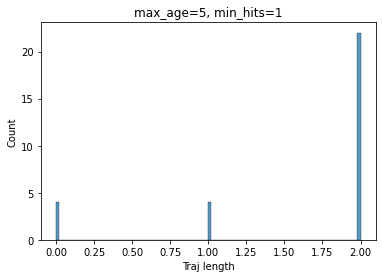

In [7]:
%matplotlib inline
import seaborn as sns
id_to_sc_trajs = traj_collection.track_id_to_trajectory
all_traj_lengths = np.array([_traj.get_timeframe_span_length() for _traj in id_to_sc_trajs.values()])
sns.histplot(all_traj_lengths, bins=100)
plt.title("max_age={}, min_hits={}".format(MAX_AGE, MIN_HITS))
plt.ylabel("Count")
plt.xlabel("Traj length")
plt.show()